# 02: Data exploration, validation and cleaning

### Import

In [1]:
import numpy as np
import pandas as pd
import sklearn as skit
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.stats import chi2_contingency

import seaborn as sns
import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Data load

In [2]:
df = pd.read_csv('data.csv')

## Data types & measurement scales
Data types from a content point of view:

* **Nominal (categorical)** - Individual values without any quantitative meaning and inherent order. Used as labels.
* **Dichotomous** - Same as nominal with only two possible values.
* **Ordinal** - Nominal with order which is important and significant. The meaning of differences between values is not specified.
* **Numeric discrete** - Ordered and differences have a clear meaning.
* **Numeric continuous (interval/ratio)** - Any value in some admissible range.
* **Multidimensional** - Combinations of previous, represented as texts, vectors etc.

Data types from a storage point of view:
* **Int** - Nominal, Dichotomous, Ordinal and Numeric discrete.
* **Float** - Everything one dimensional.
* **Text** - Nominal, Dichotomous, and Multidimensional. Usually not numeric meaning.
* **Date** - Intenrally corresponds to Numeric continuous or discrete.
* etc.

In [3]:
# Obtain basic data info
display(df.info())
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


None

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Show object dtype data 

df.select_dtypes(include=['int64']).head()
df.select_dtypes(include=['float64']).head()
df.select_dtypes(include=['object']).head()

# Different data types (measurement scales)

# Nominal - PassengerId, Survived, Sex (dichotomous)
# Ordinal - Pclass, Embarked
# Numeric Discrete - SibSp, Parch
# Numeric continuous - Age, Fare

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S


## Data validation 
...

### Consistency
Same things are represented in the same way.

In [5]:
# Consistency check
display(df['Sex'].unique())

array(['male', 'female', 'Female', 'Male'], dtype=object)

In [6]:
# Repair Sex representation - part of data cleaning
# - make it lowercase
df.Sex = df.Sex.str.lower()
# your code here


### Domain
Set (range) of admisible values.

In [7]:
# Counts of unique values for all columns
df.nunique()
# !!!!! nan are not counted !!!!

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [8]:
# Domain check for numerical data
display(df.describe())

# Fare has minimum 0 and max 500 - but those are valid values from the domain point of view

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
# Show minimal and maximal values
df.apply(['min', 'max'])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
min,1,0,1,??,female,0.42,0,0,110152,0.0000,C
max,891,1,3,"van Melkebeke, Mr. Philemon",male,80.00,8,6,WE/P 5735,512.3292,S


#### Boxplot 

Useful visualisation of a domain for numeric data.
* The bottom and top of the box are always the first and third quartiles. Their difference is called the inter-quartile range (IQR).
* The band inside the box is always the second quartile (the median).
* Two lines (whiskers) outside the box extends to the smallest (minimum) and largest (maximum) observation excluding outliers.
* Points correspond to “outliers” determined by the following rule of thumb: if they fall at least 1.5 IQR above the third quartile or 1.5 IQR below the first quartile.

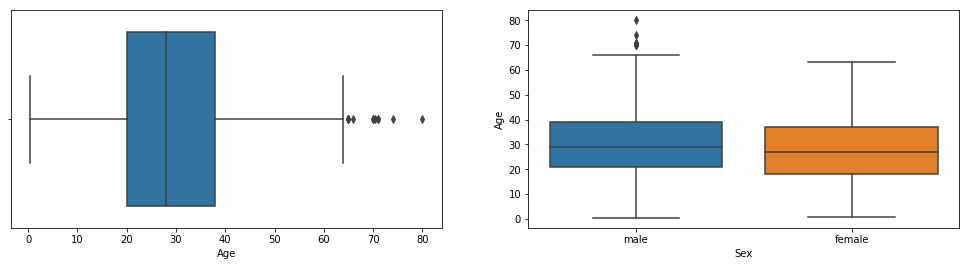

In [10]:
plt.figure(figsize=(17, 4))
plt.subplot(1,2,1)
sns.boxplot(x="Age", data=df)
plt.subplot(1,2,2)
sns.boxplot(x='Sex', y='Age', data=df)

In [11]:
# Check Name at least via its length 
# - create NameLen feature

df['NameLen'] = df['Name'].str.strip().str.len()

# your code here


df['NameLen'].describe()

count    891.000000
mean      26.945006
std        9.314499
min        2.000000
25%       20.000000
50%       25.000000
75%       30.000000
max       82.000000
Name: NameLen, dtype: float64

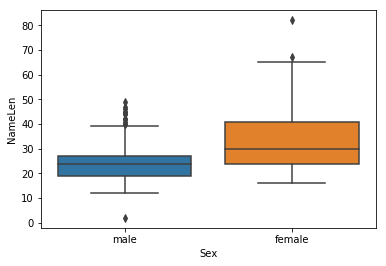

In [12]:
# Influence of Sex on NameLen
sns.boxplot(x='Sex', y='NameLen', data=df)

In [13]:
## Observe NameLen largest values
# - 3 largest

# your code here
list(df.loc[df.NameLen.nlargest(3).index]['Name'])


['Penasco y Castellana, Mrs. Victor de Satode (Maria Josefa Perez de Soto y Vallejo)',
 'Phillips, Miss. Kate Florence ("Mrs Kate Louise Phillips Marshall")',
 'Duff Gordon, Lady. (Lucille Christiana Sutherland) ("Mrs Morgan")']

In [14]:
## Observe NameLen smallest values
# - 3 shortest

# your code here
df.loc[df.NameLen.nsmallest(3).index]

# ?? will be cleaned later

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NameLen
711,712,0,1,??,male,NaN,0,0,113028,26.5500,C124,S,2
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S,12
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S,12


### Integrity of relationships between columns (logical integrity)
This type of integrity is concerned with the correctness or rationality of a piece of data, given a particular context. 
This means that values in a group of features may follow some contextual constrains. E.g. Female name should not occur for the male person.

In [17]:
# Preparation for title, firstname, and surname extraction from the name
pattern = re.compile('\A\s*([^,]+),\s*([^\.]+\.)\s*([^\(]*)\s*(\(\s*([^\)]*)\s*\))?(.*)\Z')

def split_name(name):
    if type(name) is not str:
        return np.nan, np.nan, np.nan
    else:
        m = pattern.match(name
        if m:
            res = m.groups()
            return res[1].strip(), res[0].strip(), res[2].strip()
        else:
            return np.nan, np.nan, np.nan


SyntaxError: invalid syntax (<ipython-input-17-bd7d664243de>, line 9)

In [16]:
# Integrity for name titles

# split_name("Turpin, Mrs. William John Robert ( sddf)")
df['Title'], df['Surname'], df['Firstnames'] = zip(*df.Name.apply(split_name))

# print unique titles
df['Title'].unique()

NameError: name 'split_name' is not defined

In [ ]:
# Show titles for males and females

print('Male:', list(df[df['Sex']=='male']['Title'].unique()))
print('Female:', list(df[df['Sex']=='female']['Title'].unique()))

# Show males without a title
df[(df.Sex == "male") & df.Title.isnull()]

## Data cleaning
Data cleaning is the process of detecting and correcting (or removing) corrupt or inaccurate records from data and refers to identifying incomplete, incorrect, inaccurate or irrelevant parts of the data and then replacing, modifying, or deleting the dirty or coarse data.

### Data conversion
convert data to standard format

In [ ]:
# show all non numeric fields
df.select_dtypes(include=['object']).head()

#### Pandas categorical data 
suitable for storing nominal and ordinal values

In [19]:
# Convert nominal values stored in strings to pandas categorical format
# Sex and Title
sex_category = pd.api.types.CategoricalDtype(categories=["male","female"], ordered=False)
if not pd.api.types.is_categorical_dtype(df['Sex']):
    df['Sex'] = df['Sex'].astype(sex_category)
     
# show results
display(df['Sex'].unique())

[male, female]
Categories (2, object): [male, female]

In [20]:
# Convert ordinal values
pclass_category = pd.api.types.CategoricalDtype(categories=[1,2,3], ordered=True)
if not pd.api.types.is_categorical_dtype(df['Pclass']):
    df['Pclass'] = df['Pclass'].astype(pclass_category)
    
display(df['Pclass'].describe())
display(df['Pclass'].unique())


count     891
unique      3
top         3
freq      491
Name: Pclass, dtype: int64

[3, 1, 2]
Categories (3, int64): [1 < 2 < 3]

#### Dummy indicator representation of categorical data
Flags of individual category membership.

In [21]:
# Show dummy indicators for embarked
pd.get_dummies(df['Pclass']).head()

,1,2,3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


### Convert unknown values to proper missing values

In [22]:
# Convert ?? for Name to pandas (numpy) NaN
df['Name'].replace(['??'], np.nan, inplace=True)
df['NameLen'] = df.Name.str.len()

df[['Name', 'Title']].info()
df[df.Name.isnull()]

KeyError: "['Title'] not in index"

In [ ]:
sns.boxplot(x='Sex', y='NameLen', data=df)

### Outliers detection
* single feature - rule of thumb - Outliers outside of interval (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR) where:
    * Q1 - first quartile
    * Q2 - second quartile
    * IQR - Inter Quartile Range = Q3 - Q1 (middle 50%)
    
    This rule works well for data with Gaussian like distribution.
* multiple feature - clustering techniques

In [23]:
# Single feature

# Compute IQR for all numeric lengths
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR =  Q3 - Q1

# Find outliers of Age
AgeOut = (df['Age'] > Q3['Age'] + 1.5*IQR['Age']) | (df['Age'] < Q1['Age'] - 1.5*IQR['Age'])
display(AgeOut.sum())
df[AgeOut].sort_values(['Age'], ascending = False).head()

11

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NameLen
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S,36.0
851,852,0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,NaN,S,19.0
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C,25.0
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,NaN,C,23.0
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,20.0


/home/ladislav/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


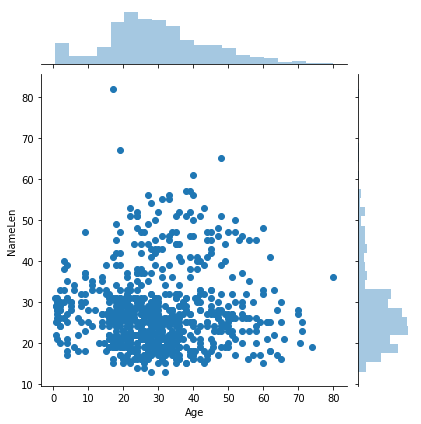

In [24]:
# multiple feature
# Analyze Age and NameLen together
sns.jointplot(x='Age', y='NameLen', data = df)

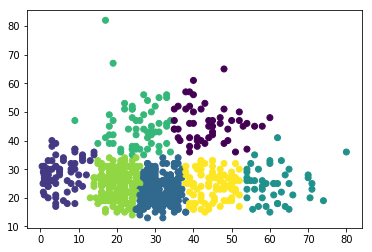

In [25]:
# K means clustering
data = df[['Age', 'NameLen']].dropna()
kmeans = KMeans(n_clusters=7, random_state=0).fit(data)

# Plot
plt.scatter(x=data.Age, y=data.NameLen, c=kmeans.labels_)

In [ ]:
# Find distances from cluster centroids
distances = kmeans.transform(data)
# see distances of the first point
distances[1,:]

In [ ]:
# Distances from nearest cluster centroid
min_distances = pd.Series(np.apply_along_axis(min, 1, distances))
# 
print(min_distances.nlargest(3).index)
# find 3 points with largest distance
df.loc[data.iloc[min_distances.nlargest(3).index].index]

In [ ]:
plt.scatter(x=data.Age, y=data.NameLen, c=kmeans.labels_)
indices = data.iloc[min_distances.nlargest(3).index].index
plt.scatter(x=data.Age[indices], y=data.NameLen[indices], c='r')

### Missing data handling

* Deletion - removing of rows / features with missing data.
* Imputation - process of replacing missing data with substituted values.

In [26]:
# Counts of nan values
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             1
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
NameLen          1
dtype: int64

In [27]:
df[df['Name'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NameLen
711,712,0,1,NaN,male,NaN,0,0,113028,26.55,C124,S,NaN


In [28]:
# Drop this row
df.drop(df.loc[df['Name'].isnull()].index, inplace=True)
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            176
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
NameLen          0
dtype: int64

In [29]:
# drop columns with too many nans
if 'Cabin' in df:
    df.drop('Cabin', 1, inplace = True)

#### Age imputation

In [30]:
# Age imputation is complicated!

# Search if missing Age is somehow related with survival
nanAge_category = pd.api.types.CategoricalDtype(categories=[False, True], ordered=True)
if not 'NaNAge' in df:
    df['NaNAge'] = df['Age'].isnull().astype(nanAge_category)

table = pd.crosstab(df.Survived, df.NaNAge,  margins=True)
display(table)
table2 = table.mul(100).floordiv(table.iloc[:,-1], axis=0).astype(str) + '%'
display(table2)

NaNAge,False,True,All
Survived,,,
0,424,124,548
1,290,52,342
All,714,176,890


NaNAge,False,True,All
Survived,,,
0,77%,22%,100%
1,84%,15%,100%
All,80%,19%,100%


In [31]:
# Test the independence
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df.NaNAge, df.Survived), correction=False)
print('P-value:', p)
# They are not independent
# Therefore we cannot assume MCAR (missing completely at random). 
# MAR (missing at random) might be valid and we can try to impute - but should do that carefully.

P-value: 0.0068421613035539045


In [ ]:
# Lets observe the dependence of Age on Title

sns.boxplot(x='Title', y='Age', data=df)

In [ ]:
# Median of Ages per different Titles
df.groupby('Title').Age.median()

In [ ]:
# Fill missing Age values by per Title median values
df.loc[df['NaNAge']==True, 'Age'] = df[df['NaNAge']==True].Title.apply(lambda x: df.groupby('Title').Age.median()[x])

In [ ]:
sns.distplot(df.Age, bins=20, kde = True, rug=True)

More sophisticated method is the **KNN based imputation**

In [34]:
# choose columns to compute nearest neighbors
NNcolumns = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Title']

# get data into numpy array
data = df.loc[:, NNcolumns].copy()
for column in data.select_dtypes(['category']).columns:
    data[column] = data[column].cat.codes

# transform categories to indicators
data = pd.get_dummies(data)

# X - points where we know the Age
X = data[df.NaNAge == False].values
Xidx = data[df.NaNAge == False].index

# Y - points where the Age should be imputed
Y = data[df.NaNAge == True].values
Yidx = data[df.NaNAge == True].index

# training with 5 neighbours
neighbors = NearestNeighbors(5)
neighbors.fit(X)

# get 5 neighbors for each point
Yn = neighbors.kneighbors(Y, return_distance=False)

/home/ladislav/.local/lib/python3.5/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [33]:
# Prepare a new variable
df['NewAge'] = df.Age

# Impute with mean of 5 nearest neighbours
for i in range(Yn.shape[0]):
    ages = [df.Age[Xidx[idx]] for idx in Yn[i,:]]
    df.loc[Yidx[i], 'NewAge'] = np.mean(ages)

NameError: name 'Yn' is not defined

In [ ]:
display(df.info())

In [ ]:
# See some results 
# Note that Age is not NaN since it was previously imputed with medians!
df.loc[Yidx[0:2],:]

In [32]:
# Correlation between previous median imputation based on Titles and this KNN based imputation
df[df.NaNAge == True][['Age', 'NewAge']].corr()

KeyError: "['NewAge'] not in index"